In [1]:
# Standard libraries
import os
from glob import glob
import itertools
import pickle

# Basic 3rd party libraries
import pandas as pd
import numpy as np

# Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# scikit processing
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report

# scikit models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

# TensorFlow Keras API
from tensorflow.keras.utils import (
    plot_model as tf_plot,
    to_categorical,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy

# TensorFlow Keras model and layers API
from tensorflow.keras.layers import (
    Input,
    Reshape,
    Flatten,
    Conv1D,
    Conv2D,
    MaxPooling1D,
    MaxPooling2D,
    Dense,
    Dropout,
    Concatenate,
)
from tensorflow.keras.models import (
    Sequential,
    Model,
    load_model as tf_load_model,
)



## Mounting Google Drive and setting resources path (path to captures)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

resources_dir = '/content/drive/MyDrive/honours/captures'

print(os.path.exists(resources_dir))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
True


## Setting configs


In [3]:
# Directory storing the CSI and WLAN captures
resources_dir = '/content/drive/MyDrive/honours/captures'

# Directory to save plots to
plt_dir = '/content/drive/MyDrive/honours/figures/csi'

# Directory to save models to
models_dir = '/content/drive/MyDrive/honours/models'

# Supress pd scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Resolution of plots
plt.rcParams["figure.dpi"] = 100 # 300
plt.rcParams["figure.dpi"] = 500 # 300

# Backend to generate plots
# mpl.use("agg")
# %matplotlib ipympl
%matplotlib inline

# plt figure style
fig_style = "seaborn-v0_8-whitegrid"

# colormaps
cmap_qual = "pastel"
cmap_seq = "viridis"
cmap_cycl = "twilight"
cmap_intsy = "Blues"

# Hide warnings
import warnings
warnings.filterwarnings("ignore")


## Helper Funcs for Results Analysis

In [4]:
def load_report(
    name,
    my_model_dir,
    lab_grouping=None,
):
    """
    """
    # Getting filename for classification report
    if lab_grouping:
        lab_grouping_str = "".join([str(i) for i in lab_grouping])
        fp = os.path.join(my_model_dir, f"{name}_report_{lab_grouping_str}.csv")
    else:
        fp = os.path.join(my_model_dir, f"{name}_report.csv")
    # Returning report DF
    return pd.read_csv(
        fp,
        header=0,
        index_col=0,
    )


def load_results(
    name,
    my_model_dir,
):
    """
    """
    # Getting filename for results
    fp = os.path.join(my_model_dir, f"{name}_res.h5")
    # Returning results DF
    return pd.read_hdf(
        fp,
        key="results",
        mode="r"
    )


def load_pkl(
    name,
    get_my_model_dir,
    suffix=""
):
    """
    Loads the .pkl file object from a folder (given by name)
    """
    my_model_dir = get_my_model_dir(name, get_my_model_dir)
    # Getting filepaths
    obj_fp = os.path.join(my_model_dir, f"{name}_{suffix}.pkl")
    # Loading object
    with open(obj_fp, "rb") as f:
        obj = pickle.load(f)
    return obj


def plot_confusion_matrix(
    cm,
    classes,
    title='Confusion matrix',
    **kwargs
):
    """
    To plot heatmap of confusion matrix
    """
    # Initialising figure and axes
    with plt.style.context(fig_style):
        fig = plt.figure(
            figsize=(8, 8),
            layout="constrained"
        )
        ax = fig.subplots()
    # Making confusion matrix heatmap
    sns.heatmap(
        cm,
        annot=kwargs.get("annot", False),
        ax=ax,
        cmap=kwargs.get("cmap", cmap_intsy),
        fmt=kwargs.get("fmt", ".2f"),
        cbar=kwargs.get("cbar", True),
        xticklabels=classes,
        yticklabels=classes,
    )
    # Set titles
    ax.tick_params(labelsize="small")
    ax.set_title(title, fontsize="xx-large")
    ax.set_xlabel("Predicted", fontsize="large")
    ax.set_ylabel("True", fontsize="large")
    # Return figure and axis
    return fig, ax


# def eval_model(
#     name,
#     lab_grouping=None,
# ):
#     """
#     Evaluate the given model from the saved results h5.
#     Can also group on the given labels (e.g., only (devices, videos))
#     """
#     my_model_dir = get_my_model_dir(name)
#     # Reading in results
#     res = pd.read_hdf(
#         os.path.join(my_model_dir, f"{name}_res.h5"),
#         key="results",
#         more="r"
#     )
#     # Making label groupings for evaluation
#     if lab_grouping:
#         res = res.assign(
#             y_true=lambda x: ["|".join(i) for i in np.array(res["y_true"].str.split("|").values.tolist())[:, lab_grouping]],
#             y_pred=lambda x: ["|".join(i) for i in np.array(res["y_pred"].str.split("|").values.tolist())[:, lab_grouping]],
#         )

#     # Getting classes
#     classes = np.sort(res["y_true"].unique())

#     # Making confusion matrix
#     # rows = true, columns = predicted
#     cm = confusion_matrix(
#         y_true=res["y_true"],
#         y_pred=res["y_pred"],
#         labels=classes,
#         normalize=None,
#     )
#     # Plotting confusion matrix
#     fig, ax = plot_confusion_matrix(
#         cm,
#         classes,
#         title=f"{name} Classifier Results",
#         annot=True,
#         cmap="Blues",
#         fmt=".0f",
#     )
#     fig.savefig(os.path.join(my_model_dir, f"{name}_cm.png"))
#     # Classification report
#     print(classification_report(
#         res["y_true"],
#         res["y_pred"],
#         target_names=classes,
#     ))
#     (
#         pd.DataFrame(classification_report(
#             res["y_true"],
#             res["y_pred"],
#             target_names=classes,
#             output_dict=True,
#         ))
#         .transpose()
#         .to_csv(os.path.join(my_model_dir, f"{name}_report.csv"))
#     )


## Making Accuracies DF

In [146]:
# Different input, model, and target combinations for baseline models
inputs = {
    "wlan": "WLAN",
    "csi": "CSI",
}
mls = {
    "knn": "KNN",
    "svc_ovo": "SVM",
    "MLP_V1": "MLP",
    "CNN_V2": "CNN",
}
targets = {
    "d": "Device",
    "l": "Location",
    "v": "Video",
}

# Initialising accuracies df
accuracies_df = pd.DataFrame(
    columns=["Input", "Model", "Target", "Accuracy"],
)

# For each baseline model, get the classification report's accuracy
for i, j, k in itertools.product(inputs, mls, targets):
    # Getting report
    report = load_report(
        name=j,
        my_model_dir=os.path.join(models_dir, i, k, j),
        lab_grouping=None,
    )
    # Adding accuracy to df
    accuracies_df.loc[accuracies_df.shape[0]] = [
        inputs[i],
        mls[j],
        targets[k],
        report.loc["accuracy"][0],
    ]

# For each XL-NTA target output, get the classification report's accuracy
for i_i, i_v in enumerate(targets):
    # Getting report
    report = load_report(
        name="XL-NTA",
        my_model_dir=os.path.join(models_dir, "comb", "d_l_v", "XL-NTA"),
        lab_grouping=[i_i],
    )
    # Adding accuracy to df
    accuracies_df.loc[accuracies_df.shape[0]] = [
        "Combined",
        "XL-NTA",
        targets[i_v],
        report.loc["accuracy"][0],
    ]

accuracies_df["Accuracy"] = accuracies_df["Accuracy"] * 100

display(accuracies_df)


,Input,Model,Target,Accuracy
0,WLAN,KNN,Device,90.155440
1,WLAN,KNN,Location,51.398964
2,WLAN,KNN,Video,65.284974
3,WLAN,SVM,Device,99.170984
4,WLAN,SVM,Location,63.834197
5,WLAN,SVM,Video,76.062176
6,WLAN,MLP,Device,97.823834
7,WLAN,MLP,Location,63.626943
8,WLAN,MLP,Video,79.170984
9,WLAN,CNN,Device,96.580311


## Plotting

### Individual Barplots

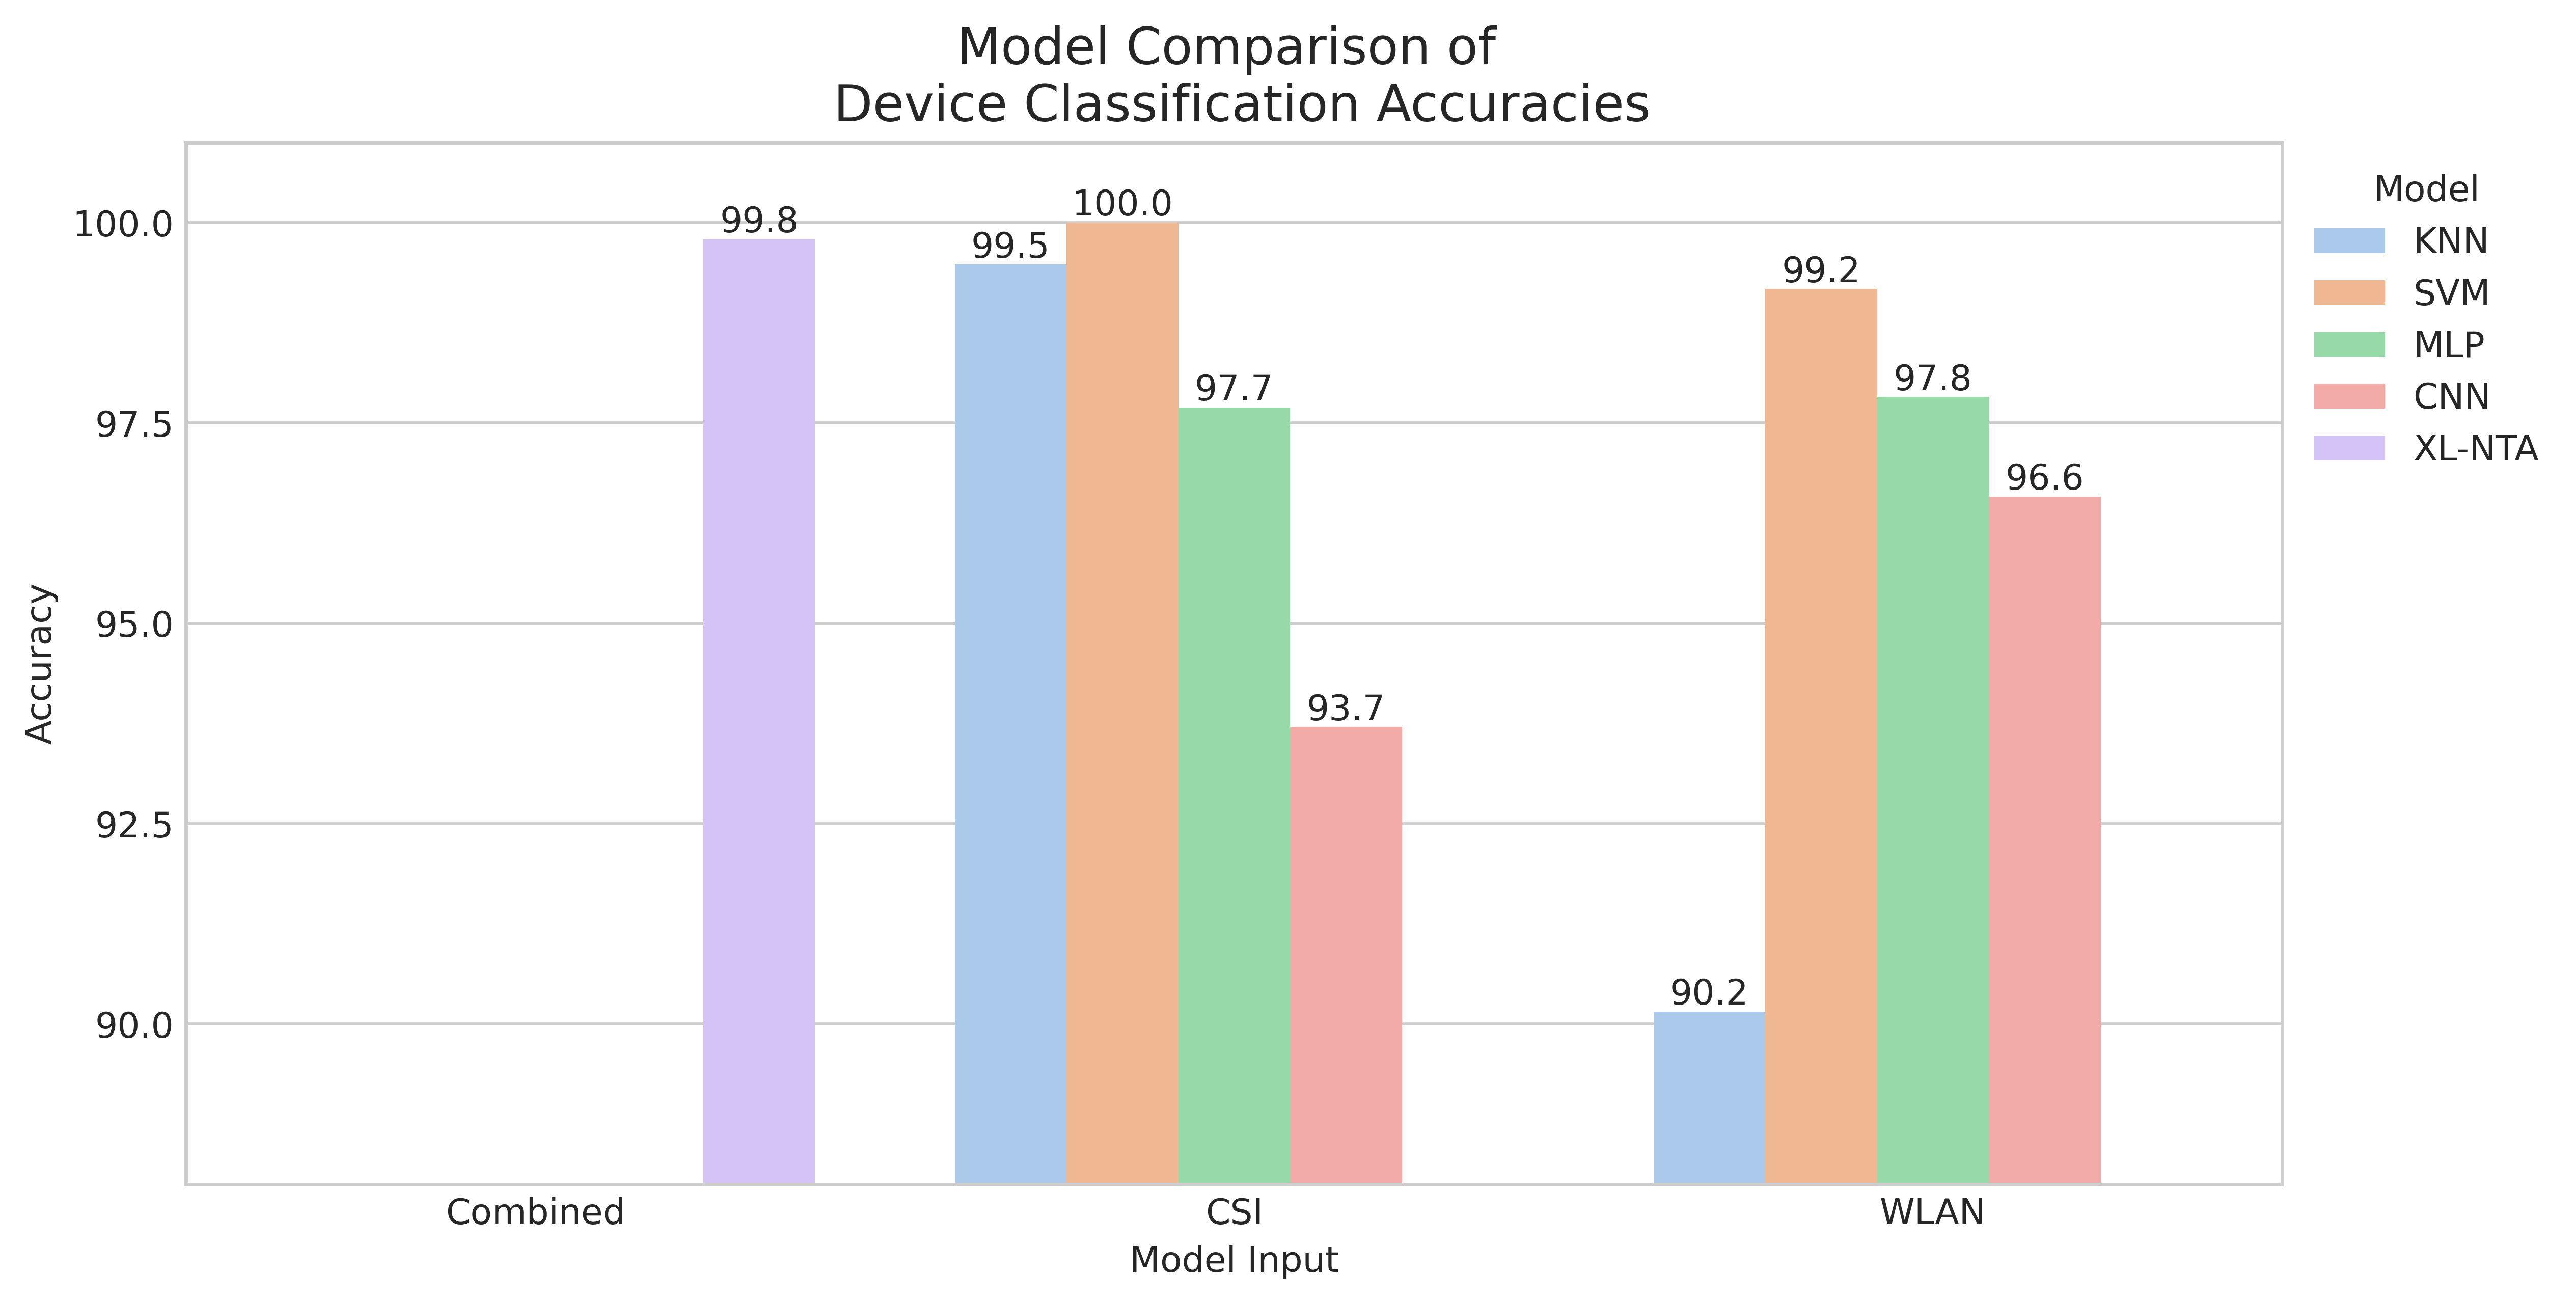

In [148]:
my_target = list(targets.values())[0]

# PLOTTING
with plt.style.context(fig_style):
    fig = plt.figure(figsize=(10, 5), layout="constrained")
    ax = fig.subplots()
    sns.barplot(
        data=accuracies_df[accuracies_df["Target"] == my_target],
        x="Input", # Input, Model
        y="Accuracy",
        hue="Model", # Input, Model
        order=["Combined", "CSI", "WLAN"],
        hue_order=["KNN", "SVM", "MLP", "CNN", "XL-NTA"],
        dodge=True,
        # alpha=0.8,
        palette=cmap_qual,
        errorbar=None,
        ax=ax,
    )
    sns.move_legend(
        ax,
        loc="upper left",
        bbox_to_anchor=(1, 1),
    )
    for c in ax.containers:
        ax.bar_label(c, fmt="%.1f", label_type="edge", fontsize=10)
    ax.set_yticks(np.arange(0, 110, 2.5))
    ax.set_ylim(88, 101)
    ax.set_title(f"Model Comparison of \n {my_target} Classification Accuracies", fontsize="x-large")
    ax.set_xlabel("Model Input")


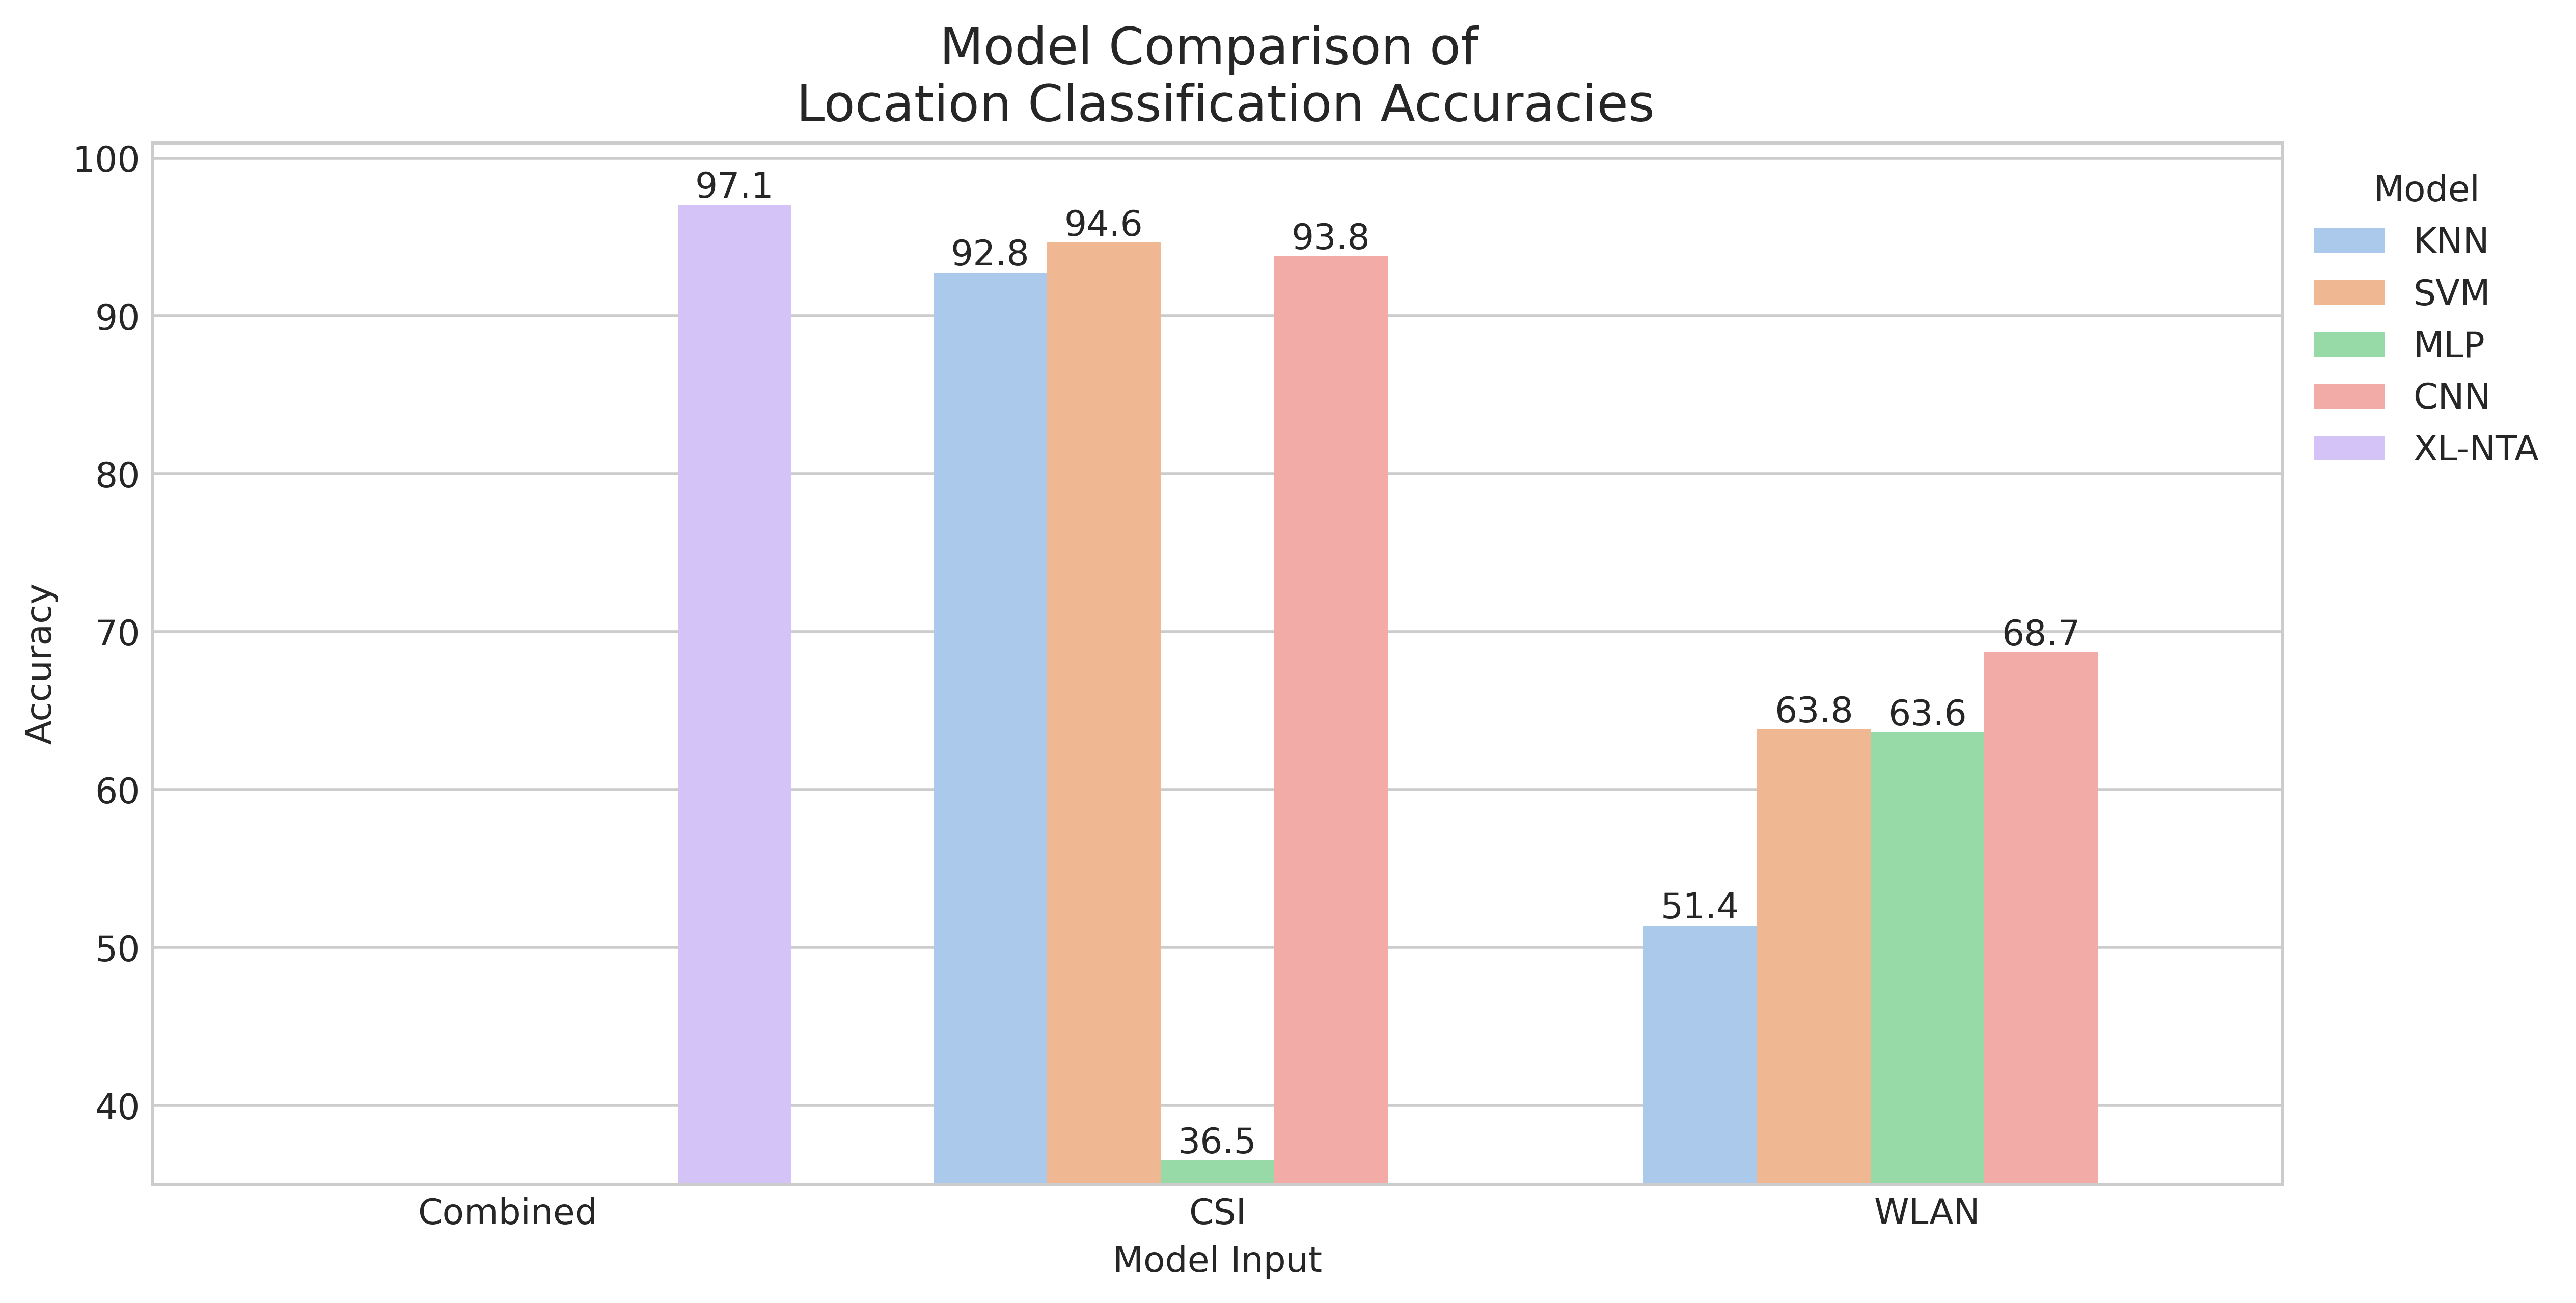

In [149]:
my_target = list(targets.values())[1]

# PLOTTING
with plt.style.context(fig_style):
    fig = plt.figure(figsize=(10, 5), layout="constrained")
    ax = fig.subplots()
    sns.barplot(
        data=accuracies_df[accuracies_df["Target"] == my_target],
        x="Input", # Input, Model
        y="Accuracy",
        hue="Model", # Input, Model
        order=["Combined", "CSI", "WLAN"],
        hue_order=["KNN", "SVM", "MLP", "CNN", "XL-NTA"],
        dodge=True,
        # alpha=0.8,
        palette=cmap_qual,
        errorbar=None,
        ax=ax,
    )
    sns.move_legend(
        ax,
        loc="upper left",
        bbox_to_anchor=(1, 1),
    )
    for c in ax.containers:
        ax.bar_label(c, fmt="%.1f", label_type="edge", fontsize=10)
    ax.set_yticks(np.arange(0, 110, 10))
    ax.set_ylim(35, 101)
    ax.set_title(f"Model Comparison of \n {my_target} Classification Accuracies", fontsize="x-large")
    ax.set_xlabel("Model Input")


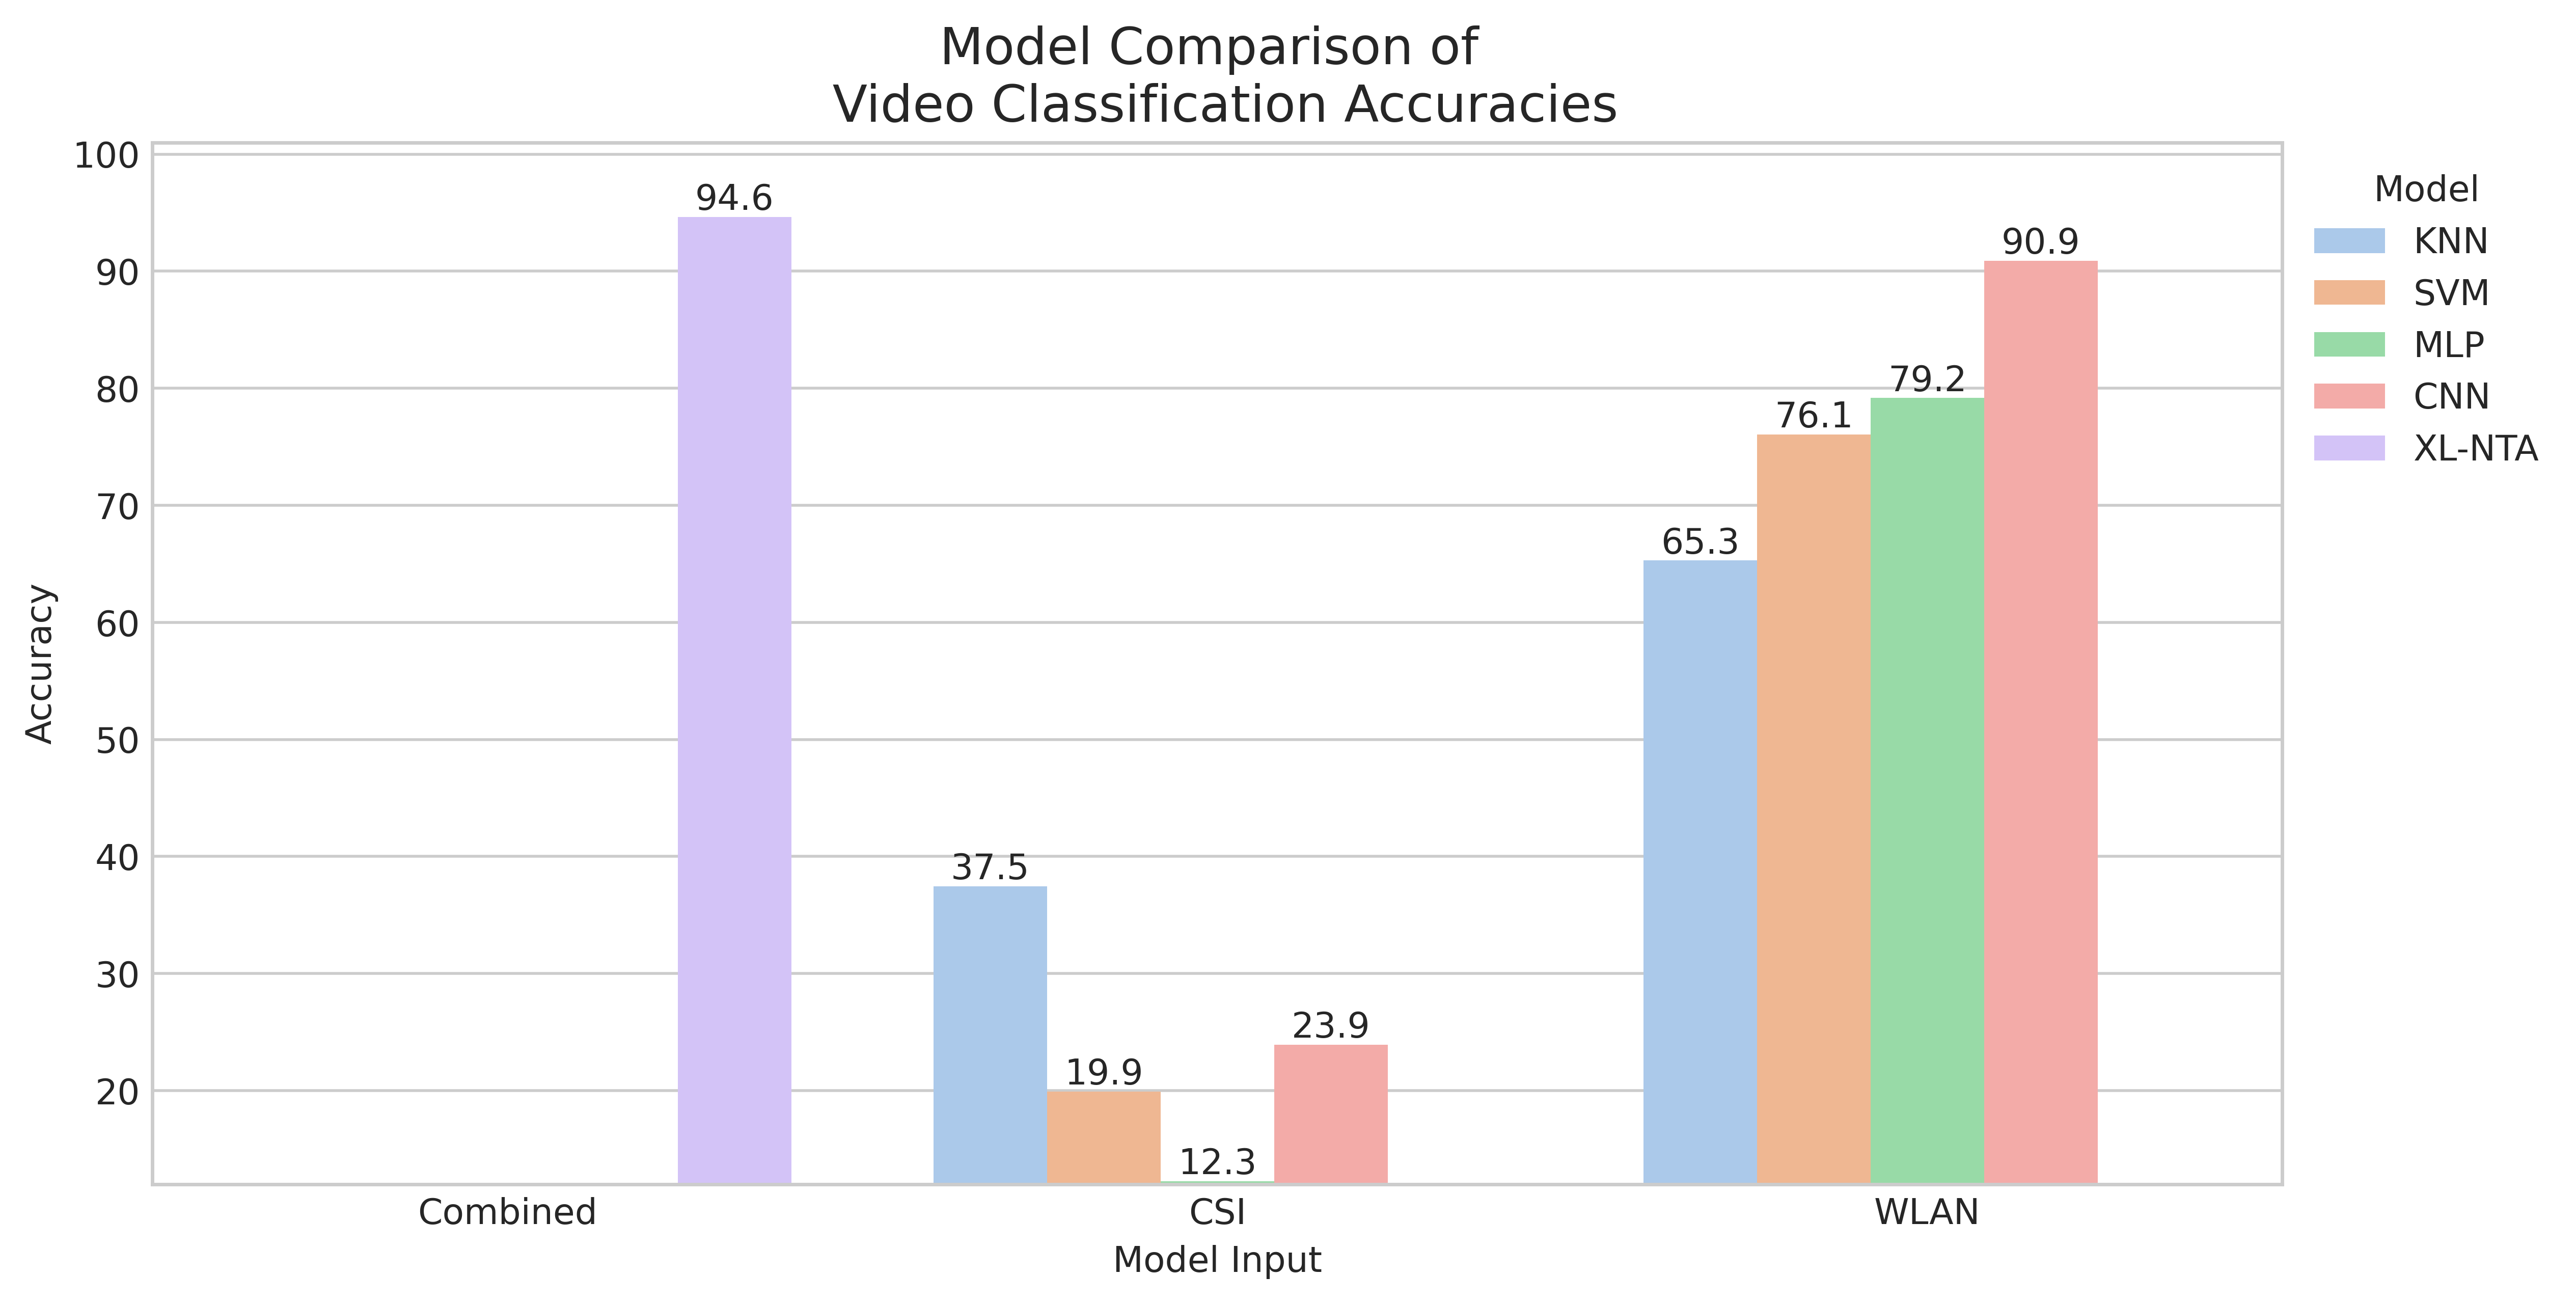

In [150]:
my_target = list(targets.values())[2]

# PLOTTING
with plt.style.context(fig_style):
    fig = plt.figure(figsize=(10, 5), layout="constrained")
    ax = fig.subplots()
    sns.barplot(
        data=accuracies_df[accuracies_df["Target"] == my_target],
        x="Input", # Input, Model
        y="Accuracy",
        hue="Model", # Input, Model
        order=["Combined", "CSI", "WLAN"],
        hue_order=["KNN", "SVM", "MLP", "CNN", "XL-NTA"],
        dodge=True,
        # alpha=0.8,
        palette=cmap_qual,
        errorbar=None,
        ax=ax,
    )
    sns.move_legend(
        ax,
        loc="upper left",
        bbox_to_anchor=(1, 1),
    )
    for c in ax.containers:
        ax.bar_label(c, fmt="%.1f", label_type="edge", fontsize=10)
    ax.set_yticks(np.arange(0, 110, 10))
    ax.set_ylim(12, 101)
    ax.set_title(f"Model Comparison of \n {my_target} Classification Accuracies", fontsize="x-large")
    ax.set_xlabel("Model Input")


### Facet Barplot

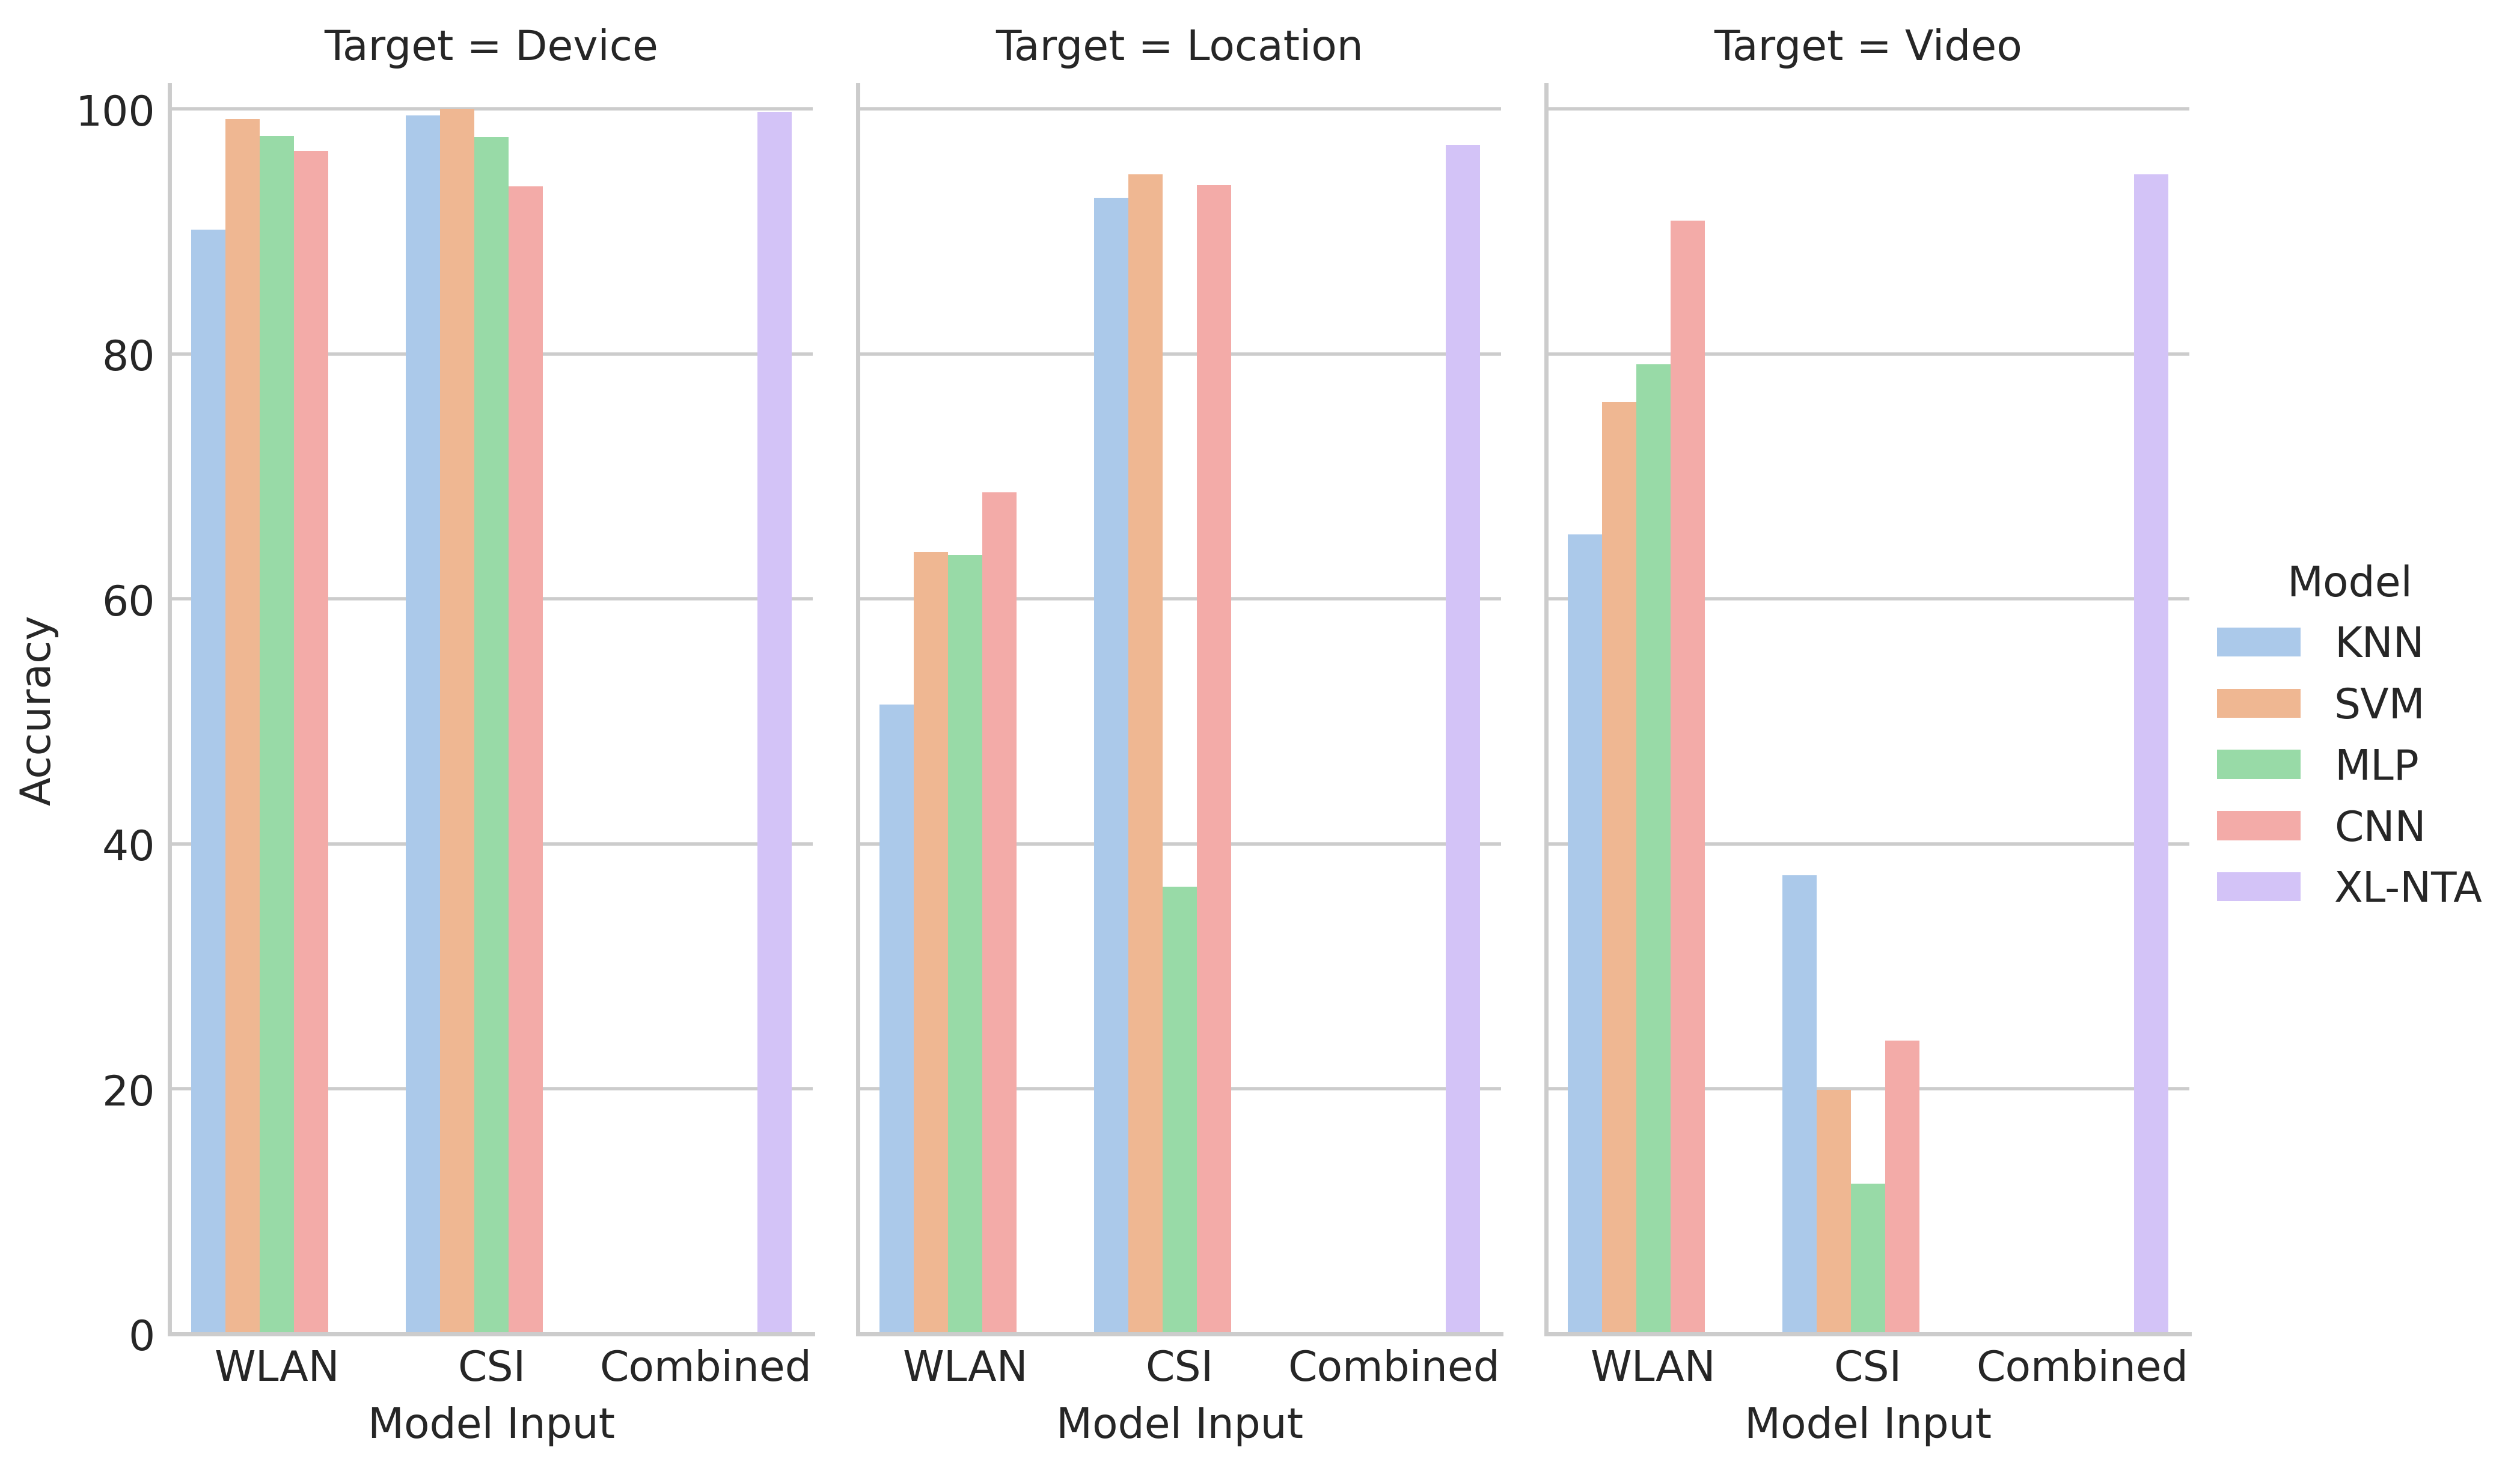

In [145]:
my_target = list(targets.values())[0]

# PLOTTING
with plt.style.context(fig_style):
    g = sns.catplot(
        data=accuracies_df,
        x="Input", # Input, Model
        y="Accuracy",
        hue="Model", # Input, Model
        col="Target", # Target
        kind="bar",
        dodge=True,
        # gap=0.1,
        # alpha=0.8,
        legend_out=True,
        palette=cmap_qual,
        errorbar=None,
        height=5,
        aspect=0.5,
    )
    g.set(
        ylim=(0, 102)
    )
    g.set_titles(
        row_template="Target: {col_name}",
    )
    g.set_axis_labels(
        x_var="Model Input",
    )

